In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX


In [3]:
# --------------------
# CONFIG
# --------------------
DATA_PATH = "../DATA/Combined_UVA_Tuition_Cleaned.csv"
OUT_DIR   = "../OUTPUT/05_dual_holt_arima/"
COL_YEAR  = "Year_Start"
COL_GAP   = "Tuition_Gap"

TEST_YEARS        = 10
FORECAST_END_YEAR = 2030
MIN_TRAIN_YEAR    = 1990   

ARIMA_ORDERS = [(0,1,1), (0,1,2), (1,1,1)]
ARIMA_TRENDS = ['t', 'c', None]  

os.makedirs(OUT_DIR, exist_ok=True)

In [4]:
# --------------------
# Helpers
# --------------------
def mape(y_true, y_pred):
    y_true, y_pred = np.asarray(y_true), np.asarray(y_pred)
    denom = np.where(y_true == 0, 1e-9, np.abs(y_true))
    return float(np.mean(np.abs((y_true - y_pred) / denom)) * 100.0)

def r2(y_true, y_pred):
    y_true, y_pred = np.asarray(y_true), np.asarray(y_pred)
    ss_res = np.sum((y_true - y_pred) ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return float(1 - ss_res / ss_tot) if ss_tot != 0 else np.nan

def fit_best_arima_resid(residuals, orders=ARIMA_ORDERS, trends=ARIMA_TRENDS):
    best = {"aic": np.inf, "order": None, "trend": None, "fit": None}
    for order, trend in product(orders, trends):
        try:
            model = SARIMAX(residuals, order=order, trend=trend,
                            enforce_stationarity=False, enforce_invertibility=False)
            fit = model.fit(disp=False, maxiter=400)
            if fit.aic < best["aic"]:
                best.update({"aic": fit.aic, "order": order, "trend": trend, "fit": fit})
        except Exception:
            continue
    if best["fit"] is None:
        raise RuntimeError("No ARIMA candidate converged on residuals.")
    return best


In [5]:
# --------------------
# Load & prepare
# --------------------
df = pd.read_csv(DATA_PATH)
df[COL_YEAR] = pd.to_numeric(df[COL_YEAR], errors="coerce")
df[COL_GAP]  = pd.to_numeric(df[COL_GAP],  errors="coerce")
df = df.dropna(subset=[COL_YEAR, COL_GAP]).sort_values(COL_YEAR).reset_index(drop=True)

# (Optional) limit to modern era to boost generalization to recent test years
df = df[df[COL_YEAR] >= MIN_TRAIN_YEAR].reset_index(drop=True)

years   = df[COL_YEAR].to_numpy(dtype=int)
gap_all = df[COL_GAP].to_numpy(dtype=float)


In [6]:
# --------------------
# Split train/test
# --------------------
split_idx  = max(0, len(df) - TEST_YEARS)
train_years, test_years = years[:split_idx], years[split_idx:]
y_train, y_test         = gap_all[:split_idx], gap_all[split_idx:]

print(f"Train years: {train_years[0]}–{train_years[-1]} | Test years: {test_years[0]}–{test_years[-1]}")

# --------------------
# Step 1: Holt (damped) on train
# --------------------
holt = ExponentialSmoothing(
    y_train, trend="add", damped_trend=True, seasonal=None,
    initialization_method="estimated"
).fit()

holt_train_fitted   = holt.fittedvalues
holt_test_forecast  = holt.forecast(len(y_test))

Train years: 1990–2013 | Test years: 2014–2023


In [7]:
# --------------------
# Step 2: ARIMA on Holt residuals (train)
# --------------------
residuals_train = y_train - holt_train_fitted
best = fit_best_arima_resid(residuals_train)
order, trend, arima_fit = best["order"], best["trend"], best["fit"]
print(f"Best ARIMA on residuals by AIC: order={order}, trend={trend}, AIC={best['aic']:.2f}")

# Forecast residuals over test horizon
resid_test_forecast = arima_fit.get_forecast(steps=len(y_test)).predicted_mean


Best ARIMA on residuals by AIC: order=(0, 1, 2), trend=c, AIC=307.39


In [8]:
# --------------------
# Step 3: Hybrid = Holt + ARIMA(resid)
# --------------------
hybrid_test_forecast = holt_test_forecast + resid_test_forecast

# Evaluate on test (levels, per rubric)
hybrid_r2   = r2(y_test, hybrid_test_forecast)
hybrid_mape = mape(y_test, hybrid_test_forecast)
last_n = min(5, len(y_test))
if last_n > 0:
    dir_true = np.sign(np.diff(y_test[-(last_n+1):]))
    dir_pred = np.sign(np.diff(np.asarray(hybrid_test_forecast)[-(last_n+1):]))
    hybrid_dir = float((dir_true == dir_pred).mean())
else:
    hybrid_dir = np.nan

print(f"Hybrid Holt+ARIMA (damped + {order}, trend={trend}) "
      f"→ Test R²={hybrid_r2:.3f}, MAPE={hybrid_mape:.2f}%, Direction(last5)={hybrid_dir:.2f}")

# Save test predictions
pd.DataFrame({
    "year": test_years,
    "gap_actual": y_test,
    "holt_forecast": holt_test_forecast,
    "arima_resid_forecast": resid_test_forecast,
    "hybrid_forecast": hybrid_test_forecast
}).to_csv(f"{OUT_DIR}/hybrid_test_predictions.csv", index=False)


Hybrid Holt+ARIMA (damped + (0, 1, 2), trend=c) → Test R²=0.218, MAPE=6.79%, Direction(last5)=1.00


In [9]:
# --------------------
# Refit on FULL & Forecast to 2030
# --------------------
# Holt on full
holt_full = ExponentialSmoothing(
    gap_all, trend="add", damped_trend=True, seasonal=None,
    initialization_method="estimated"
).fit()
steps_ahead = int(FORECAST_END_YEAR - years[-1])
if steps_ahead > 0:
    holt_full_fc = holt_full.forecast(steps_ahead)
else:
    holt_full_fc = np.array([])

# ARIMA on full residuals, same best order/trend
resid_full = gap_all - holt_full.fittedvalues
arima_full = SARIMAX(
    resid_full, order=order, trend=trend,
    enforce_stationarity=False, enforce_invertibility=False
).fit(disp=False, maxiter=400)

if steps_ahead > 0:
    resid_future_fc = arima_full.get_forecast(steps=steps_ahead).predicted_mean
    hybrid_future_fc = holt_full_fc + resid_future_fc
    future_years = np.arange(years[-1] + 1, FORECAST_END_YEAR + 1, dtype=int)

    pd.DataFrame({
        "year": future_years,
        "gap_forecast_hybrid": hybrid_future_fc
    }).to_csv(f"{OUT_DIR}/hybrid_future_forecast_2030.csv", index=False)
else:
    future_years = np.array([], dtype=int)
    hybrid_future_fc = np.array([])


In [10]:
# --------------------
# Save metrics
# --------------------
pd.DataFrame([{
    "holt": "damped add-trend",
    "arima_on_residuals_order": str(order),
    "arima_on_residuals_trend": str(trend),
    "test_R2": hybrid_r2,
    "test_MAPE": hybrid_mape,
    "directional_accuracy_last5": hybrid_dir
}]).to_csv(f"{OUT_DIR}/hybrid_metrics.csv", index=False)


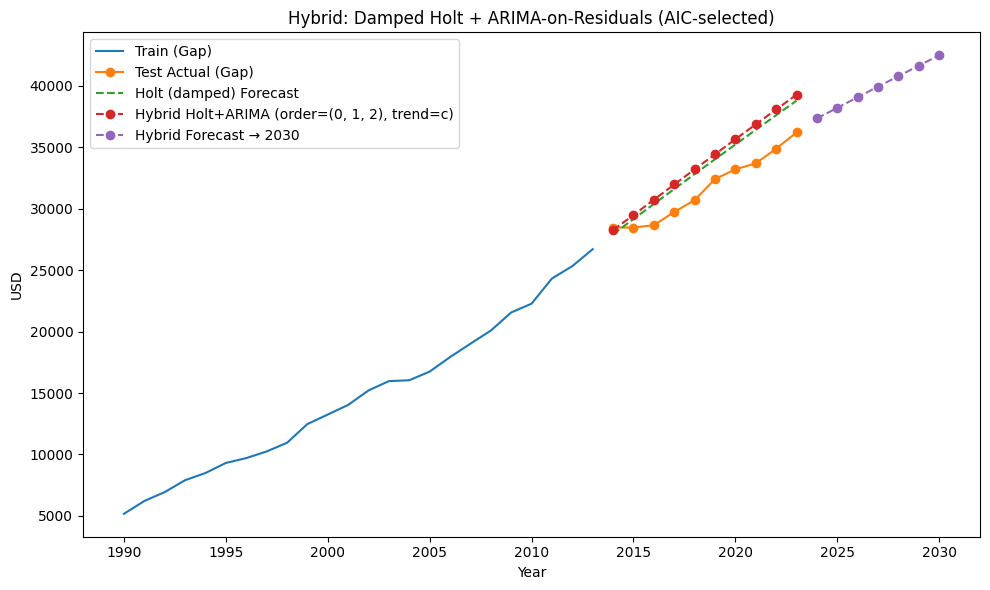

Saved: ../OUTPUT/05_dual_holt_arima//hybrid_test_predictions.csv, ../OUTPUT/05_dual_holt_arima//hybrid_future_forecast_2030.csv ../OUTPUT/05_dual_holt_arima//hybrid_metrics.csv, ../OUTPUT/05_dual_holt_arima//hybrid_gap_forecast.png


In [11]:
# --------------------
# Plot
# --------------------
plt.figure(figsize=(10,6))
plt.plot(train_years, y_train, label="Train (Gap)")
plt.plot(test_years, y_test, marker="o", label="Test Actual (Gap)")
plt.plot(test_years, holt_test_forecast, linestyle="--", label="Holt (damped) Forecast")
plt.plot(test_years, hybrid_test_forecast, marker="o", linestyle="--",
         label=f"Hybrid Holt+ARIMA (order={order}, trend={trend})")

if future_years.size > 0:
    plt.plot(future_years, hybrid_future_fc, marker="o", linestyle="--", label="Hybrid Forecast → 2030")

plt.title("Hybrid: Damped Holt + ARIMA-on-Residuals (AIC-selected)")
plt.xlabel("Year"); plt.ylabel("USD")
plt.legend(); plt.tight_layout()
plt.savefig(f"{OUT_DIR}/hybrid_gap_forecast.png", dpi=200)
plt.show()

print("Saved:",
      f"{OUT_DIR}/hybrid_test_predictions.csv,",
      f"{OUT_DIR}/hybrid_future_forecast_2030.csv" if future_years.size > 0 else "(no future file)",
      f"{OUT_DIR}/hybrid_metrics.csv,",
      f"{OUT_DIR}/hybrid_gap_forecast.png")